# Support Vector Machines with Gaussian and ANOVA kernels

In [162]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV

In [163]:
# read csv and save output as numpy array
df = np.loadtxt('mnistsub.csv', delimiter=',')

In [164]:
df[:5] # print top 5 rows

array([[ 1.36637569,  1.26868557,  9.        ],
       [-3.66552531,  2.79492899,  3.        ],
       [-5.10868841,  1.75740888,  5.        ],
       [-4.20791081,  1.83797115,  3.        ],
       [-0.74175948, -1.26028311,  1.        ]])

In [166]:
# Split features and target arrays
X = df[:, :2]
y = df[:, 2].reshape(-1,1)

In [167]:
# Split dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### SVM fitting and hyperparmeters tuning

#### Tune hyperparameters for different kernels using predefined split for validation

In [168]:
ps = PredefinedSplit(test_fold=y_test.ravel())
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit

#### Tune hyperparameters for Linear kernel

In [169]:
parameters = {'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
            }
svc_lin = SVC(kernel='linear')
clf_lin = GridSearchCV(svc_lin, parameters, verbose=1, cv=ps)

clf_lin.fit(X_train, y_train.ravel())
print(f'The most optimal value for Linear kernel hyperparameter C is {clf_lin.best_params_.get("C")} gives an accuracy score of {round(clf_lin.best_score_, 5)}')

Fitting 4 folds for each of 9 candidates, totalling 36 fits
The most optimal value for Linear kernel hyperparameter C is 0.4 gives an accuracy score of 0.81517


In [170]:
svc_lin = SVC(kernel='linear', C=0.4)
svc_lin.fit(X_train, y_train.ravel())

SVC(C=0.4, kernel='linear')

#### Tune hyperparameters for Gaussian kernel

In [175]:
parameters = {'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
            'gamma' : [0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
            }
svc_rbf = SVC(kernel='rbf')
clf_rbf = GridSearchCV(svc_rbf, parameters, verbose=1, cv=ps)

clf_rbf.fit(X_train, y_train.ravel())
print(f'The most optimal value for Gaussian kernel hyperparameter C at {clf_rbf.best_params_.get("C")} and gamma at {clf_rbf.best_params_.get("gamma")} gives an accuracy score of {round(clf_rbf.best_score_, 5)}')

Fitting 4 folds for each of 54 candidates, totalling 216 fits
The most optimal value for Gaussian kernel hyperparameter C at 0.9 and gamma at 0.12 gives an accuracy score of 0.82731


In [176]:
svc_rbf = SVC(kernel='rbf', C=0.9, gamma=0.12)
svc_rbf.fit(X_train, y_train.ravel())

SVC(C=0.9, gamma=0.12)

Better model accuracy achieved using Gaussian kernel

#### Tune hyperparameters for Polynominal kernel

In [181]:
parameters = {'C': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
            'degree': [1, 2, 3],
            'gamma' : [0.40, 0.5, 0.6, 0.7, 0.8, 0.9]
            }
svc_poly = SVC(kernel='poly')
clf_poly = GridSearchCV(svc_poly, parameters, verbose=1, cv=ps)

clf_poly.fit(X_train, y_train.ravel())
print(f'The most optimal value for Polynominal kernel hyperparameter C at {clf_poly.best_params_.get("C")}, polynominal degree {clf_poly.best_params_.get("degree")} and gamma {clf_poly.best_params_.get("gamma")} gives an accuracy score of {round(clf_poly.best_score_, 5)}')

Fitting 4 folds for each of 144 candidates, totalling 576 fits
The most optimal value for Polynominal kernel hyperparameter C at 0.4, polynominal degree 1 and gamma 0.7 gives an accuracy score of 0.81656


In [182]:
svc_poly = SVC(kernel='poly', C=0.4, degree=1, gamma=0.7)
svc_poly.fit(X_train, y_train.ravel())

SVC(C=0.4, degree=1, gamma=0.7, kernel='poly')

Slihtly better values comparing to a linear kernel, addding polynominal degree does not provide additional model accurcey gain

## ANOVA kernel - implmentation from scratch

In [99]:
# define function for anova kernel
# https://intellipaat.com/community/22796/how-to-use-a-custom-svm-kernel

def anova_kernel(X1, X2, sigma = 0.1, degree = 2):
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1 = x1.flatten()
            x2 = x2.flatten()
            gram_matrix[i, j] = np.power(np.sum(np.exp(-sigma*(np.power((x1 - x2),2)))), degree)
    return gram_matrix

In [ ]:
# Proof that anova_kernel is a valid kernel
# Kernel is symmetric as (x1-x2) in a power of 2 is equal to (x2-x1) in a power of 2
# Kernel is non-negative as (x1-x2) in a power of 2 is a non-negative number

#### Tune hyperparameters for ANOVA kernel

In [156]:
# define initial parameters and CV parameters
parameters = {'C': [0.6, 0.7, 0.8]}
best_C = 0
best_sigma = 0
best_degree = 0
score = 0

sigma_value = [0.3, 0.4, 0.5]
degree_value = [1, 2, 3]
svc_comp = SVC(kernel="precomputed")

# define loop to iterate through parameters
for sigma in sigma_value:
    for degree in degree_value: 
        clf_computed = GridSearchCV(svc_comp, parameters, cv=ps)
        clf_computed.fit(anova_kernel(X_train,X_train, sigma=sigma, degree=degree), y_train.ravel())
        if degree == 1: # inital values
            score = clf_computed.best_score_
            best_C = clf_computed.best_params_.get("C")
            best_sigma = sigma
            best_degree = degree
        if score < clf_computed.best_score_: # define best parameters
            score = clf_computed.best_score_
            best_C = clf_computed.best_params_.get("C")
            best_sigma = sigma
            best_degree = degree
print(f'The most optimal value for Anova kernel hyperparameter C at {best_C}, sigma value {best_sigma} and degree of {best_degree} gives an accuracy score of {round(score, 5)}')

The most optimal value for Anova kernel hyperparameter C at 0.6, sigma value 0.5 and degree of 2 gives an accuracy score of 0.81561


Accuracy score of 0.81567 is higher then using linear kernel. Further optimization will be needed in order to obtain values better then provided by Polynominal or Gaussian kernel

In [157]:
svc_anova = SVC(kernel='precomputed', C=0.6)
svc_anova.fit(anova_kernel(X_train,X_train, sigma=0.5, degree=2), y_train.ravel())

SVC(C=0.6, kernel='precomputed')

### Decision boundary for the best models together with the data

In [158]:
# Using code provided in lecture "Logistic regression", p.21 and https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

# step size in the mesh
h = .02 
# define borders
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Define meshgrid for Support vector machine model using Linear kernel
Z_lin = svc_lin.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lin = Z_lin.reshape(xx.shape)

# Define meshgrid for Support vector machine model using Gaussian kernel
Z_rbf = svc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

# Define meshgrid for Support vector machine model using Polynominal kernel
Z_poly = svc_poly.predict(np.c_[xx.ravel(), yy.ravel()])
Z_poly = Z_poly.reshape(xx.shape)

In [159]:
h = .1 # increasing mesh size due to computational time 
# define borders
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
xx_anova, yy_anova = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Define meshgrid for Support vector machine model using ANOVA kernel
Z_anova = svc_anova.predict(anova_kernel(np.c_[xx_anova.ravel(), yy_anova.ravel()], X_train, sigma=0.4, degree=1))

Z_anova = Z_anova.reshape(xx_anova.shape)

[Text(0.5, 1.0, 'Decision boundary for SVM model ANOVA Kernel')]

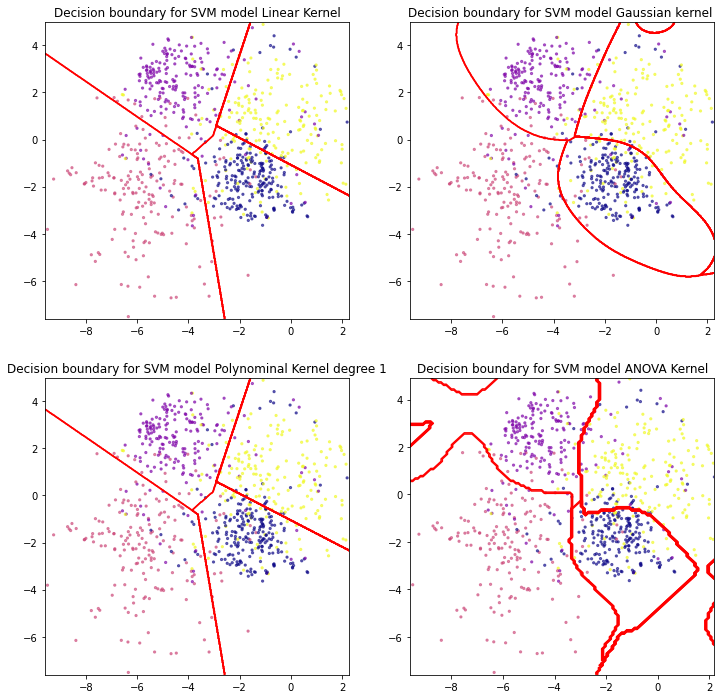

In [161]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))


# https://github.com/lilly-chen/Bite-sized-Machine-Learning/blob/master/SVM/SVM-Basics.ipynb

axs[0,0].scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', alpha=0.6, s=5)
axs[0,0].contour(xx, yy, Z_lin, colors=['r'])
axs[0,0].set(title = 'Decision boundary for SVM model Linear Kernel')

axs[0,1].scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', alpha=0.6, s=5)
axs[0,1].contour(xx, yy, Z_rbf, colors=['r'])
axs[0,1].set(title = 'Decision boundary for SVM model Gaussian kernel ')

axs[1,0].scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', alpha=0.6, s=5)
axs[1,0].contour(xx, yy, Z_poly, colors=['r'])
axs[1,0].set(title = 'Decision boundary for SVM model Polynominal Kernel degree 1')

axs[1,1].scatter(X[:, 0], X[:, 1], c=y, cmap='plasma', alpha=0.6, s=5)
axs[1,1].contour(xx_anova, yy_anova, Z_anova, colors=['r'])
axs[1,1].set(title = 'Decision boundary for SVM model ANOVA Kernel')